In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, MapDataset
from gammapy.data import Observation, observatory_locations
from regions import CircleSkyRegion
from scipy.stats import chi2, norm

import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalogHGPS

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.20.1     
	path                   : D:\Documents\Miniconda\envs\gammapy-0.20.1\lib\site-packages\gammapy 



In [4]:
print(CATALOG_REGISTRY)
catalog=SourceCatalogHGPS()
source = catalog[3]

model = source.sky_model()
print(model)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 

SkyModel

  Name                      : HESS J1018-589 B
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.196   +/-    0.09             
    amplitude                     :   9.15e-14   +/- 1.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      2.742       TeV         
    lon_0                         :    284.223   +/-    0.04 deg         
    lat_0                         :     -1.772   +/-    0.03 deg         
    sigma                         :      0.150   +/-    0.03 deg         
    e                     (frozen):      0.000                  

In [5]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 6.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [8]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.25
	duration          : 21600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [9]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

In [10]:
def simulate_range(radlist):
    list_model=[]
    spatialmodellist=[]
    
    spectral_model=PowerLawSpectralModel(
        amplitude="1e-12 cm-2 s-1 TeV-1", index=2, reference="1 TeV"
    )
    spatial_model=GaussianSpatialModel(
        lon_0="0.4 deg", lat_0="-0.6 deg", frame="galactic"  
    )
    spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
    spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5
    spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
    spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5
    for i in range(len(radlist)):
        spatialmodellist.append(spatial_model.copy())
        spatialmodellist[i].sigma.value=radlist[i]
        model = SkyModel(spectral_model, spatialmodellist[i])
        list_model.append(model)
    return list_model

In [11]:
list_model=simulate_range([0.1, 0.2, 0.3, 0.4, 0.5])

In [12]:
print(list_model[2])

SkyModel

  Name                      : kHHvUcxR
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.400   +/-    0.00 deg         
    lat_0                         :     -0.600   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         




In [13]:
def fit_dataset(model,vary_bkg=False):
    
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
 
    bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
    if vary_bkg==True:
        bkg_model.spectral_model.norm.value = np.random.normal(1,0.1)
        bkg_model.spectral_model.tilt.value = np.random.normal(0,0.05)
        
    # A faint diffuse background
    #diffuse_spec = PowerLawSpectralModel()
    #diffuse_spec.index.value = 2.7
    #diffuse_spec.amplitude.value = 1e-13
    #diffuse_spat = GaussianSpatialModel()
    #diffuse_spat = GaussianSpatialModel(frame="galactic")
    #diffuse_spat.sigma.value = 1.0
    #diffuse_spat.e.value = 0.99999
    #diffuse_spat.phi.value = 90
    #diffuse_model = SkyModel(spectral_model=diffuse_spec,
    #                         spatial_model=diffuse_spat,
    #                         name="diffuse")
        
    dataset.models =  Models([bkg_model, model])
    dataset.fake()
    # -- like an observation
    
    dataset.models = Models([bkg_model]) #  background + diffuse
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=dataset)
    L0 = result.total_stat
    print(L0)
   
    dataset.models = Models([bkg_model, model])
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=dataset)
    L1 = result.total_stat
    print(L1)
    return L0-L1, result, dataset

In [14]:
models=[]
TS = []
datasets = []
for i in range(len(list_model)):
    delt, mod, ds = fit_dataset(list_model[i],vary_bkg=False) 
    models.append(mod)
    TS.append(delt)
    datasets.append(ds)

616887.0939635878
615919.1439667037
614099.1575843475
613698.651909096
614754.6440342499
614537.2860748653
617852.3247376428
617707.8831025383
617124.4168611494
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000377965 is smaller than machine limit 0.0367789 while 0.0002 was requested
617048.3666420823


In [15]:
for _ in models:
    print(_.parameters.to_table())

  type      name      value         unit      ...    max     frozen is_norm link
-------- --------- ----------- -------------- ... ---------- ------ ------- ----
spectral      norm  1.0007e+00                ...        nan  False    True     
spectral      tilt  0.0000e+00                ...        nan   True   False     
spectral reference  1.0000e+00            TeV ...        nan   True   False     
spectral     index  1.9319e+00                ...        nan  False   False     
spectral amplitude  9.6213e-13 cm-2 s-1 TeV-1 ...        nan  False    True     
spectral reference  1.0000e+00            TeV ...        nan   True   False     
 spatial     lon_0  4.0225e-01            deg ...  9.000e-01  False   False     
 spatial     lat_0 -5.9848e-01            deg ... -1.000e-01  False   False     
 spatial     sigma  9.3668e-02            deg ...        nan  False   False     
 spatial         e  0.0000e+00                ...  1.000e+00   True   False     
 spatial       phi  0.0000e+

In [16]:
def sigma_to_ts(sigma, df=1):
    """Convert sigma to delta ts"""
    p_value = 2 * norm.sf(sigma)
    return chi2.isf(p_value, df=df)

def ts_to_sigma(ts, df=1):
    """Convert delta ts to sigma"""
    p_value = chi2.sf(ts, df=df)
    return norm.isf(0.5 * p_value)

sigma=ts_to_sigma(TS,6)
print(sigma)

[30.61540749 19.34662104 13.93639474 11.10724825  7.63082054]


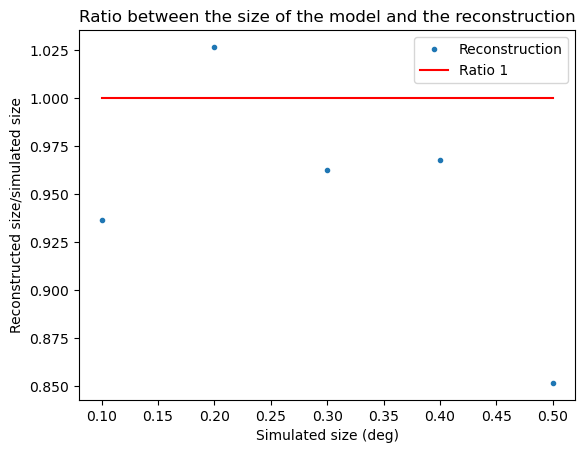

In [69]:
simsize=[0.1, 0.2, 0.3, 0.4, 0.5]
recsize=[9.3668e-02, 2.0535e-01, 2.8875e-01, 3.8713e-01, 4.2582e-01]
ratio=[]
for i in range(len(simsize)):
    ratio.append(recsize[i]/simsize[i])
plt.plot(simsize,ratio,'.',label='Reconstruction')
plt.plot([0.1,0.5],[1,1],'-r',label='Ratio 1')
plt.title('Ratio between the size of the model and the reconstruction')
plt.xlabel('Simulated size (deg)')
plt.ylabel('Reconstructed size/simulated size')
plt.legend()
plt.show()

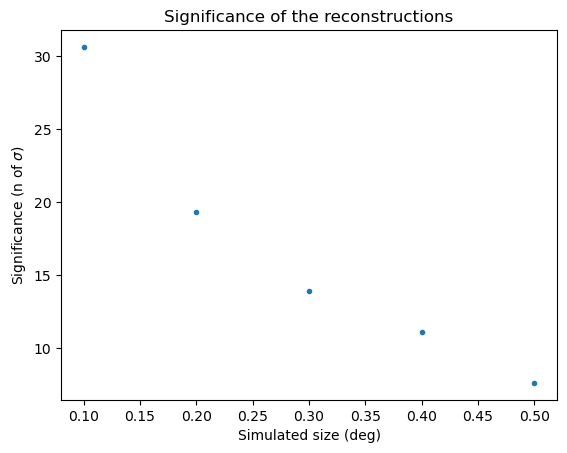

In [72]:
plt.plot(simsize,sigma,'.')
plt.title('Significance of the reconstructions')
plt.xlabel('Simulated size (deg)')
plt.ylabel(r'Significance (n of $\sigma$)')
plt.show()

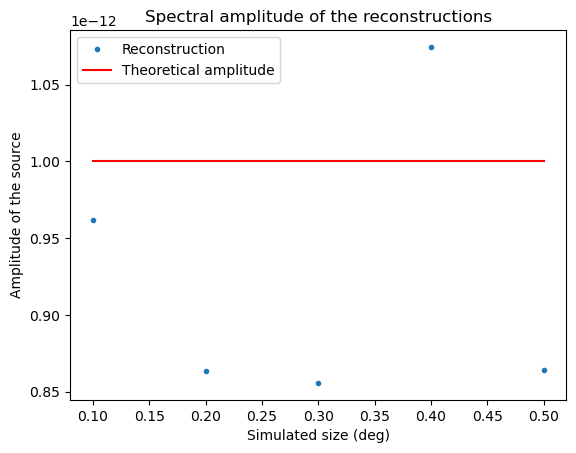

In [73]:
amprecon=[9.6213e-13, 8.6340e-13, 8.5564e-13, 1.0746e-12, 8.6427e-13]
plt.plot(simsize,amprecon,'.',label='Reconstruction')
plt.plot([0.1,0.5],[1e-12,1e-12],'-r',label='Theoretical amplitude')
plt.title('Spectral amplitude of the reconstructions')
plt.xlabel('Simulated size (deg)')
plt.ylabel('Amplitude of the source')
plt.legend()
plt.show()